In [1]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpmax, fpgrowth
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
def get_dataset():
    dataset = []
    csv_file = "../Grocery_Items_21.csv"
    data = pd.read_csv(f"{csv_file}")
    
    for i in range(len(data)):
        row_values = data.iloc[i].values
        items = [item.strip() for item in row_values if pd.notna(item)]
        dataset.append(items)
        
    return dataset

In [3]:
def get_association_rules():    
    dataset = get_dataset()   

    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
    
    print(rules)

In [4]:
get_association_rules()

          antecedents   consequents  antecedent support  consequent support  \
0  (other vegetables)  (whole milk)            0.121500             0.15475   
1        (rolls/buns)  (whole milk)            0.110750             0.15475   
2              (soda)  (whole milk)            0.096250             0.15475   
3            (yogurt)  (whole milk)            0.086625             0.15475   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.014750    0.121399  0.784486 -0.004052    0.962041      -0.238220  
1  0.012625    0.113995  0.736643 -0.004514    0.954002      -0.286751  
2  0.010125    0.105195  0.679773 -0.004770    0.944619      -0.342646  
3  0.011000    0.126984  0.820576 -0.002405    0.968195      -0.193154  


In [5]:
def extract_association():
    minimum_support=values = [0.001, 0.005, 0.01, 0.05]
    minimum_confidence_threshold = [0.05, 0.075, 0.1]
    dataset = get_dataset()   

    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = []
    rules = []
    for min_supp in minimum_support:
        for min_thresh in minimum_confidence_threshold:
            frequent_itemsets.append(fpgrowth(df, min_support=min_supp, use_colnames=True))
            rule = association_rules(frequent_itemsets[-1], metric="confidence", min_threshold=min_thresh)
            rules.append([min_thresh, min_supp, len(rule)])
    
    rules = pd.DataFrame(rules, columns=["mct", "msv", "rules"])
    rule = rules.pivot(index="mct", columns="msv", values="rules")
    sns.heatmap(rule, annot=True, fmt=".1f", cmap="crest", linewidth=0.5)

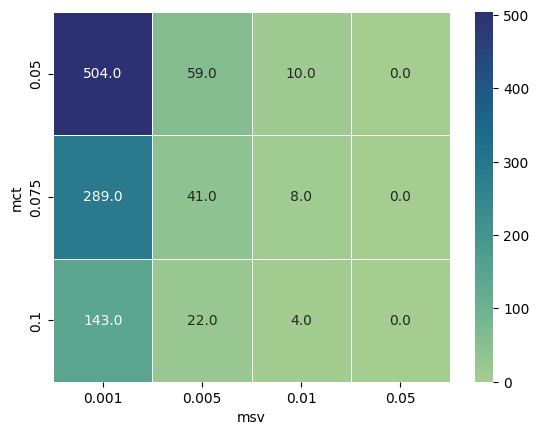

In [6]:
extract_association()

In [7]:
def get_association_rules():    
    dataset = get_dataset()   

    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(df, min_support=0.005, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
    
    rules = rules.sort_values(by='confidence', ascending=False)
    
    print(rules)

In [8]:
get_association_rules()

             antecedents         consequents  antecedent support  \
3         (bottled beer)        (whole milk)            0.046125   
18        (citrus fruit)        (whole milk)            0.053125   
21          (newspapers)        (whole milk)            0.040125   
16         (frankfurter)        (whole milk)            0.037875   
10             (sausage)        (whole milk)            0.060875   
12           (pip fruit)        (whole milk)            0.050250   
1        (bottled water)        (whole milk)            0.060250   
9               (yogurt)        (whole milk)            0.086625   
19              (pastry)        (whole milk)            0.051125   
14      (tropical fruit)        (whole milk)            0.072250   
17         (canned beer)        (whole milk)            0.045875   
0     (other vegetables)        (whole milk)            0.121500   
6        (shopping bags)        (whole milk)            0.048500   
20  (whipped/sour cream)  (other vegetables)    

The highest confidence value is 0.154472

# Image Classification using CNN 

In [9]:
def grayscale_conversion():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collect[folder] = all_files
        
    
    grayscaled_images = {}
    for folder, images in collect.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [10]:
def split_dataset():
    grayscaled_images = grayscale_conversion()
    
    training_set = {}
    testing_set = {}
    for folder in grayscaled_images:
        perce_80 = int(len(grayscaled_images[folder]) * 0.8)
        training_set[folder] = random.sample(grayscaled_images[folder], perce_80)
 
    for folder, images in grayscaled_images.items():
        combine = []
        for img in images:
            if not np.all(np.equal(img, training_set[folder]), axis=1).any():
                combine.append(img)             
        testing_set[folder] = combine
    
    return training_set, testing_set

In [11]:
def train_test_split():
    training_set, testing_set = split_dataset()
    
    X_train, y_train, X_test, y_test = ([] for i in range(4))
    
    count = 0
    for training_folder in training_set:
        for training_image in training_set[training_folder]:
            X_train.append(training_image.ravel())
            y_train.append(count)
        count += 1
    
    count = 0
    for testing_folder in testing_set:
        for testing_image in testing_set[testing_folder]:
            X_test.append(testing_image.ravel())
            y_test.append(count)
        count += 1
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [12]:
def standardized_dataset():
    a, y_train, b, y_test = train_test_split()
     
    standard = StandardScaler()
    X_train = standard.fit_transform(a)
    X_test = standard.transform(b)
        
    return X_train, y_train, X_test, y_test

In [13]:
def images_classifier():
    num_classes = 4
    input_shape = (100, 100, 1)
    
    model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"), 
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Flatten(), 
        layers.Dense(16, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ]
    )
    
    model.summary()
    
    return model

In [14]:
def train_model():
    batch_size = 128
    num_epochs = 30
    model = images_classifier()
    X_train, y_train, X_test, y_test = standardized_dataset()
    
    X_train = np.reshape(X_train, (X_train.shape[0], 100, 100, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 100, 100, 1))
    
    y_train = to_categorical(y_train, num_classes=4)
    y_test = to_categorical(y_test, num_classes=4)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)
    
    return model, history, X_test, y_test

In [15]:
def model_evaluation():
    model, history, X_test, y_test = train_model()
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\n\nTest loss:", score[0])
    print("Test accuracy:", score[1])
    
    return history

In [16]:
model = model_evaluation()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 19208)             0         
                                                                 
 dense (Dense)               (None, 16)                307344    
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 307492 (1.17 MB)
Trainable params: 307492 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

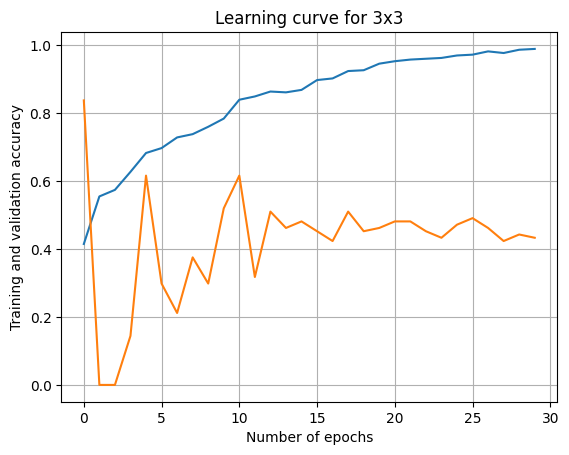

In [17]:
def plot_learning_curve():    
    plt.plot(model.history["accuracy"], label="Training Accuracy")
    plt.plot(model.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training and validation accuracy")
    plt.title("Learning curve for 3x3")
    plt.grid(True)
    plt.show()
    
plot_learning_curve()

# The last digit of my banner id is 1

In [18]:
def cnn_classifier_1():
    num_classes = 4
    input_shape = (100, 100, 1)
    
    model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Flatten(), 
        layers.Dense(16, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ]
    )
    
    model.summary()
    
    return model

In [19]:
def fit_model_1():
    batch_size = 128
    num_epochs = 30
    model = cnn_classifier_1()
    X_train, y_train, X_test, y_test = standardized_dataset()
    
    X_train = np.reshape(X_train, (X_train.shape[0], 100, 100, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 100, 100, 1))
    
    y_train = to_categorical(y_train, num_classes=4)
    y_test = to_categorical(y_test, num_classes=4)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)
    
    return model, history, X_test, y_test

In [20]:
def evaluate_model_1():
    model, history, X_test, y_test = fit_model_1()
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\n\nTest loss:", score[0])
    print("Test accuracy:", score[1])
    
    return history

In [21]:
history_1 = evaluate_model_1()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        416       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                589840    
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 590324 (2.25 MB)
Trainable params: 590324 (2.25 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

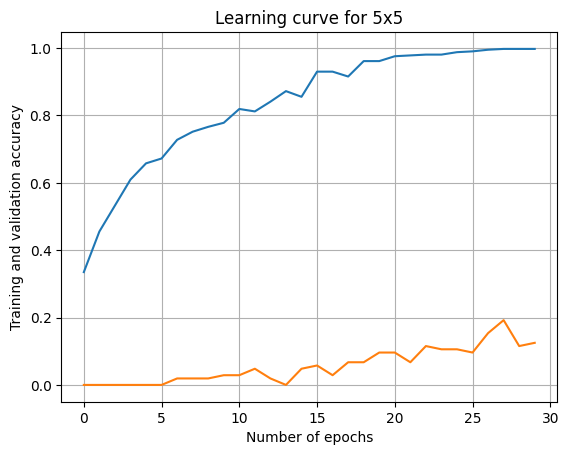

In [22]:
def plot_new_curve_1():    
    plt.plot(history_1.history["accuracy"], label="Training Accuracy")
    plt.plot(history_1.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training and validation accuracy")
    plt.title("Learning curve for 5x5")
    plt.grid(True)
    plt.show()
    
plot_new_curve_1()

In [23]:
def cnn_classifier_2():
    num_classes = 4
    input_shape = (100, 100, 1)
    
    model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        layers.Conv2D(16, kernel_size=(7, 7), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Flatten(), 
        layers.Dense(16, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ]
    )
    
    model.summary()
    
    return model

In [24]:
def fit_model_2():
    batch_size = 128
    num_epochs = 30
    model = cnn_classifier_2()
    X_train, y_train, X_test, y_test = standardized_dataset()
    
    X_train = np.reshape(X_train, (X_train.shape[0], 100, 100, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 100, 100, 1))
    
    y_train = to_categorical(y_train, num_classes=4)
    y_test = to_categorical(y_test, num_classes=4)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)
    
    return model, history, X_test, y_test

In [25]:
def evaluate_model_2():
    model, history, X_test, y_test = fit_model_2()
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\n\nTest loss:", score[0])
    print("Test accuracy:", score[1])
    
    return history

In [26]:
history_2 = evaluate_model_2()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        800       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 47, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 35344)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                565520    
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 566388 (2.16 MB)
Trainable params: 566388 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

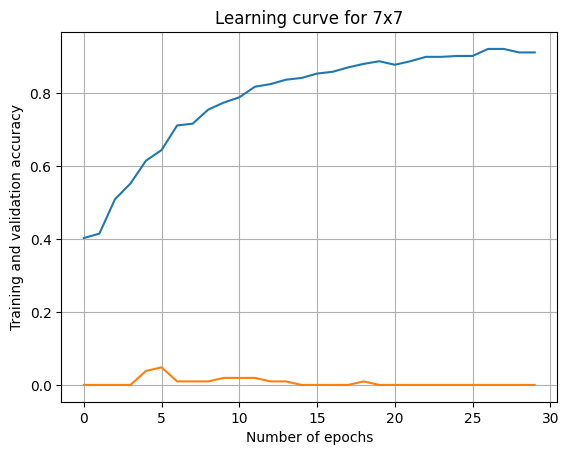

In [27]:
def plot_new_curve_2():    
    plt.plot(history_2.history["accuracy"], label="Training Accuracy")
    plt.plot(history_2.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training and validation accuracy")
    plt.title("Learning curve for 7x7")
    plt.grid(True)
    plt.show()
    
plot_new_curve_2()

The model with the 3x3 filter size has the best accuracy with 57%, while the 5x5 model has the lowest with 45%. Additionally, the 5x5 model has the highest test loss with 2.18, while the 3x3 has the lowest with 1.65. Overall, all the models are underfitting since their accuracy 57&, 45% and 51% for 3x3, 5x5 and 7x7 respectivley.